# Model for the electro-mechanical behavior of elastic organic transistors

Reynolds, V.G., Oh, S., Xie, R. and Chabinyc, M.L., 2020. Model for the electro-mechanical behavior of elastic organic transistors. Journal of Materials Chemistry C, 8(27), pp.9276-9285.

https://doi.org/10.1039/D0TC01181A

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab
from pylab import cm

mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [22]:
# Define voltage parameters
V_DD = 40; # supply voltage, V
V_resolution = 100; # number of datapoints for the voltage transfer curve
V_in = np.linspace(0,V_DD,V_resolution)
V_out = np.linspace(0,V_DD,V_resolution)

# Set the deformation range (extension ratio, er)
# Note: the deformation range must include the perfectly undeformed state (er=1)

er = np.array([0.5, 0.75, 1, 1.5, 2])
#er = np.linspace(0.5,2,100)
er_1_idx = (np.abs(er - 1)).argmin()

if 1 not in er:
    print('The range of extension ratios to be modeled must include 1 (the undeformed state).')

In [3]:
# Define a class that describes our elastic transistors

class transistor():
    
    def __init__(self, flavor, Ttype, W, L, d, C_G, mu, V_T, deformAxis):
        
        # Flavor of transistor: TFT, EDLT, or OECT
        self.flavor = flavor
        
        # Transistor type (p-type or n-type)
        self.Ttype = Ttype
        
        # Channel width and length
        self.W = W
        self.L = L
        
        # Thickness of the semiconducting layer; only needs to be defined for OECTs
        self.d = d
        
        # Gate capacitance, F/m^2 for TFT and EFLT; for OECT this is volumetric capacitance, F/m^3
        self.C_G = C_G
        
        # Mobility, m^2/Vs
        self.mu = mu
        
        # Threshold voltage (V)
        self.V_T = V_T
        
        # Deformation axis (options: along channel length "L" or along channel width "W")
        self.deformAxis = deformAxis
        
        self.I_SD = []
        self.I_SD_rel = []
        
        if Ttype == 'n':
            self.V_G = V_in
            self.V_SD = V_out
            self.I_SD_maxidx = len(self.V_G)-1
        elif Ttype == 'p':
            self.V_G = V_in-V_DD
            self.V_SD = V_out-V_DD
            self.I_SD_maxidx = 0
            
        self.V_SD_satidx = np.abs(np.abs(self.V_SD)-np.abs(V_DD)).argmin()
        
        # Define the constant beta, the strain-dependent V_T, and the strain-dependent C_G based on transistor type
        
        if flavor == 'TFT':
            self.beta = (W/L)*mu*C_G
            self.V_T_er = V_T*(er**(-1/2))
            self.C_G_er = C_G*(er**(1/2))
            if deformAxis == 'L':
                self.geo_er = (W/L)*(er**(-3/2))
            elif deformAxis == 'W':
                self.geo_er = (W/L)*(er**(3/2))
                
        elif flavor == 'EDLT':
            self.beta = (W/L)*mu*C_G
            self.V_T_er = V_T*np.ones(len(er))
            self.C_G_er = C_G*np.ones(len(er))
            if deformAxis == 'L':
                self.geo_er = (W/L)*(er**(-3/2))
            elif deformAxis == 'W':
                self.geo_er = (W/L)*(er**(3/2))
                
        elif flavor == 'OECT':
            self.beta = (W/L)*d*mu*C_G
            self.V_T_er = V_T*np.ones(len(er))
            self.C_G_er = C_G*np.ones(len(er))
            if deformAxis == 'L':
                self.geo_er = (W/L)*d*(er**(-2))
            elif deformAxis == 'W':
                self.geo_er = (W/L)*d*er
                
        else:
            print('Not a valid flavor of transistor.')
            

In [4]:
ntype = transistor(flavor='TFT',
                   Ttype='n', 
                   W=1, 
                   L=1, 
                   d=1E-7, 
                   C_G=5E-5, 
                   mu=1E-4, 
                   V_T=10,
                   deformAxis='L')

In [5]:
ptype = transistor(flavor='TFT',
                   Ttype='p', 
                   W=1, 
                   L=1, 
                   d=1E-7, 
                   C_G=5E-5, 
                   mu=1E-4, 
                   V_T=-10,
                   deformAxis='L')

In [6]:
# Function to calculate the source-drain current vs. deformation

def calculate_I_SD(er, transistor):
    
    I_SD = np.zeros((np.size(transistor.V_SD,0), np.size(transistor.V_G,0), np.size(er,0)))
    
    for i in range(np.size(er,0)):
        for j in range(np.size(transistor.V_G,0)):
            for k in range(np.size(transistor.V_SD,0)):
                if abs(transistor.V_G[j])<abs(transistor.V_T_er[i]):
                    I_SD[k,j,i]=0
                elif abs(transistor.V_SD[k])<abs(transistor.V_G[j]-transistor.V_T_er[i]): # linear regime
                    I_SD[k,j,i]=transistor.geo_er[i]*transistor.C_G_er[i]*transistor.mu*(((transistor.V_G[j]-transistor.V_T_er[i])*transistor.V_SD[k])-((transistor.V_SD[k]**2)/2))
                elif abs(transistor.V_SD[k])>=abs(transistor.V_G[j]-transistor.V_T_er[i]): # saturation regime
                    I_SD[k,j,i]=transistor.geo_er[i]*transistor.C_G_er[i]*transistor.mu*(((transistor.V_G[j]-transistor.V_T_er[i])**2)/2)
    
    return I_SD

In [7]:
# Function to calculate the relative source-drain current (I_SD/I_SD(er=1)) in the saturation regime
# The value of V_G that gives the highest magnitude I_SD is used

def calculate_relativeI_SD(er, transistor):
    
    I_SDrel = np.zeros(len(er))
                       
    for i in range(len(er)):
        I_SDrel[i] = transistor.I_SD[transistor.V_SD_satidx,transistor.I_SD_maxidx,i]/transistor.I_SD[transistor.V_SD_satidx,transistor.I_SD_maxidx,er_1_idx]

    return I_SDrel

In [8]:
# Calculate the source-drain current vs. deformation for the p-type and n-type TFTs

ntype.I_SD = calculate_I_SD(er, ntype)
ptype.I_SD = calculate_I_SD(er, ptype)

# Calculate the relative source-drain current (I_SD/I_SD(er=1)) for the p-type and n-type TFTs

ntype.I_SDrel = calculate_relativeI_SD(er, ntype)
ptype.I_SDrel = calculate_relativeI_SD(er, ptype)

In [10]:
# Build the voltage transfer curve (V_TC) by finding where the n- and p-type load curves cross
# The accuracy of this calculation depends on your voltage scan resolution, V_resolution

V_out_cross = np.zeros((np.size(V_in,0),np.size(er,0)))
for i in range(np.size(er,0)):
    for j in range (np.size(V_in,0)):
        for k in range (np.size(V_out,0)):
            if ntype.I_SD[k,j,i]>=ptype.I_SD[k,j,i]:
                V_out_cross[j,i]=V_out[k]
                break

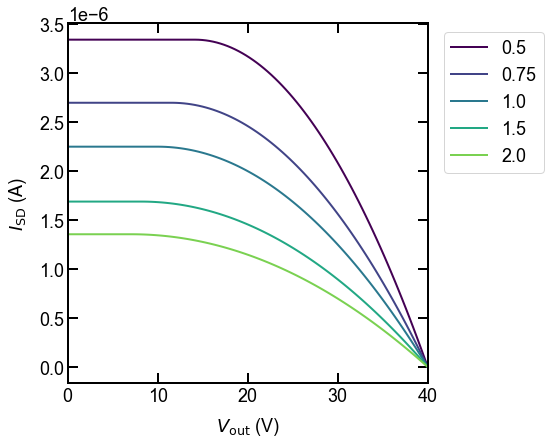

In [11]:
# Plot a series of load curves vs. deformation for the n-type transistor with V_in = 40 V

er_plot = np.array([0.5, 0.75, 1, 1.5, 2])

idx_er = np.zeros((np.size(er_plot)))

for i in range((np.size(er_plot))):
    idx_er[i] = (np.abs(er - er_plot[i])).argmin()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.set_xlim(0, np.max(V_out))
#ax.set_ylim(0, 1.05*np.max(I_SD_n[:,:,idx_er]))

ax.set_xlabel('$V_\mathrm{out}$ (V)', labelpad=10)
ax.set_ylabel('$I_\mathrm{SD}$ (A)', labelpad=10)

cm = pylab.get_cmap('viridis')

for i in range((np.size(er_plot,0))):
    #ax.plot(V_out, ntype.I_SD[:,int(np.size(ntype.I_SD,1)-1),int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(er_plot)), label=(str(er_plot[i])))
    ax.plot(V_out, ptype.I_SD[:,0,int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(er_plot)), label=(str(er_plot[i])))
    
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

#plt.savefig('Final_Plot.png', dpi=300, transparent=False, bbox_inches='tight')

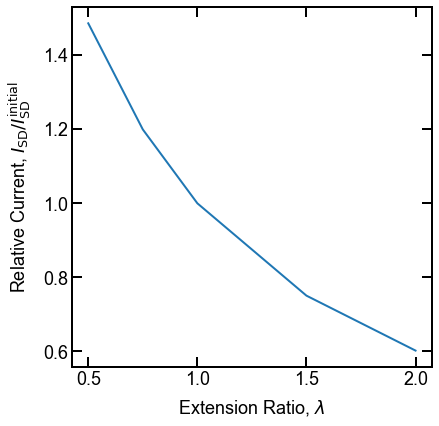

In [19]:
# Plot relative source-drain current in the saturation regime vs. extension ratio

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.set_xlabel('Extension Ratio, $\lambda$', labelpad=10)
ax.set_ylabel('Relative Current, $I_\mathrm{SD}/I_\mathrm{SD}^\mathrm{initial}$', labelpad=10)

ax.plot(er, ntype.I_SDrel, linewidth=2)

plt.show()

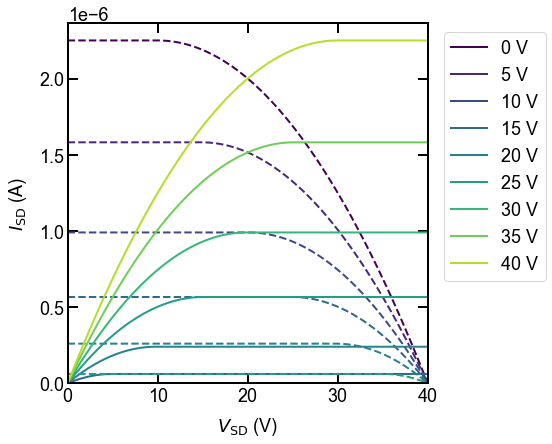

In [31]:
# Plot a series of load curves

# Set deformation
er_LC_plot = 1

# Set list of V_in's
V_in_LC_plot = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])

idx_er = (np.abs(er - er_LC_plot)).argmin()
idx_n = np.zeros((np.size(V_in_LC_plot)))
idx_p = np.zeros((np.size(V_in_LC_plot)))

for i in range((np.size(V_in_LC_plot))):
    idx_n[i] = (np.abs(ntype.V_G - V_in_LC_plot[i])).argmin()

for i in range((np.size(V_in_LC_plot))):
    idx_p[i] = (np.abs(ptype.V_G - (V_in_LC_plot[i]-V_DD))).argmin()
    
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.set_xlim(0, V_DD)
ax.set_ylim(0, 1.05*np.max(ntype.I_SD[:,:,idx_er]))

ax.set_xlabel('$V_\mathrm{SD}$ (V)', labelpad=10)
ax.set_ylabel('$I_\mathrm{SD}$ (A)', labelpad=10)

cm = pylab.get_cmap('viridis')

for i in range((np.size(V_in_LC_plot))):
    ax.plot(V_out, ntype.I_SD[:,int(idx_n[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(V_in_LC_plot[i])+' V'))
    ax.plot(V_out, ptype.I_SD[:,int(idx_p[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), linestyle='--')

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

#plt.savefig('Final_Plot.png', dpi=300, transparent=False, bbox_inches='tight')

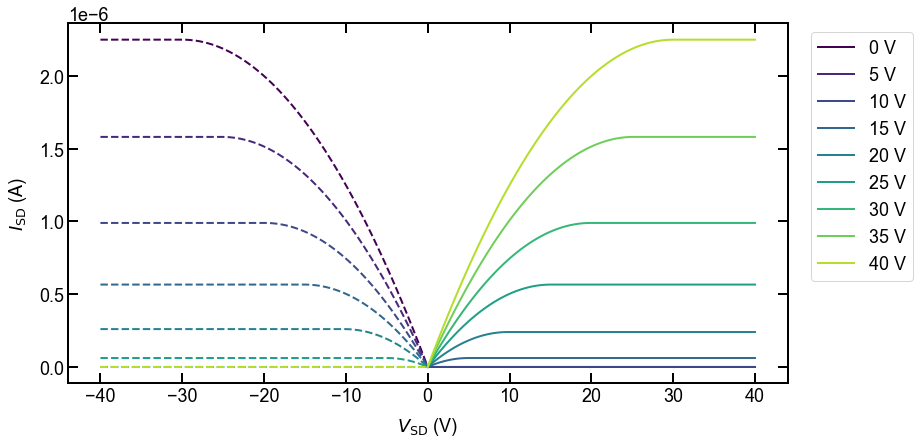

In [14]:
# Plot a series of load curves

# Set deformation
er_LC_plot = 1

# Set list of V_in's
V_in_LC_plot = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])

idx_er = (np.abs(er - er_LC_plot)).argmin()
idx_n = np.zeros((np.size(V_in_LC_plot)))
idx_p = np.zeros((np.size(V_in_LC_plot)))

for i in range((np.size(V_in_LC_plot))):
    idx_n[i] = (np.abs(ntype.V_G - V_in_LC_plot[i])).argmin()

for i in range((np.size(V_in_LC_plot))):
    idx_p[i] = (np.abs(ptype.V_G - (V_in_LC_plot[i]-V_DD))).argmin()
    
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.set_xlabel('$V_\mathrm{SD}$ (V)', labelpad=10)
ax.set_ylabel('$I_\mathrm{SD}$ (A)', labelpad=10)

cm = pylab.get_cmap('viridis')

for i in range((np.size(V_in_LC_plot))):
    ax.plot(ntype.V_SD, ntype.I_SD[:,int(idx_n[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(V_in_LC_plot[i])+' V'))
    ax.plot(ptype.V_SD, ptype.I_SD[:,int(idx_p[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), linestyle='--')

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

#plt.savefig('Final_Plot.png', dpi=300, transparent=False, bbox_inches='tight')

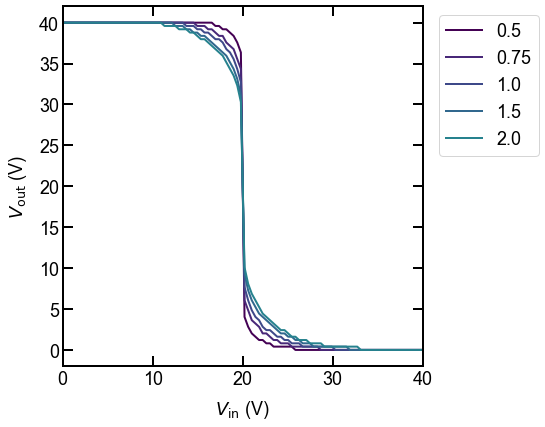

In [15]:
# Plot the voltage transfer curve of the inverter vs. deformation

er_plot = np.array([0.5, 0.75, 1, 1.5, 2])

idx_er = np.zeros((np.size(er_plot)))

for i in range((np.size(er_plot))):
    idx_er[i] = (np.abs(er - er_plot[i])).argmin()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.set_xlim(np.min(V_in), np.max(V_in))
ax.set_ylim((np.min(V_out_cross)-0.05*np.max(V_out_cross)), 1.05*np.max(V_out_cross))

ax.set_xlabel('$V_\mathrm{in}$ (V)', labelpad=10)
ax.set_ylabel('$V_\mathrm{out}$ (V)', labelpad=10)

cm = pylab.get_cmap('viridis')

for i in range((np.size(er_plot,0))):
    ax.plot(V_in, V_out_cross[:,int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(er_plot[i])))
    
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

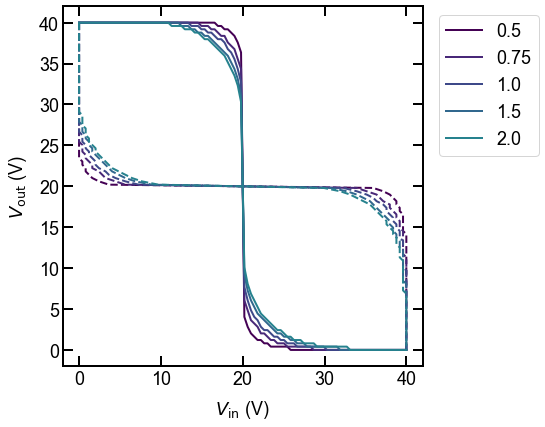

In [16]:
# Generate flipped and rotated V_TC for creating eye plot

eye_x = np.zeros((np.size(V_out_cross,0),np.size(er,0)))
eye_y = np.zeros((np.size(V_out_cross,0),np.size(er,0)))

for i in range(np.size(er,0)):
    eye_x[:,i] = -V_out_cross[:,i]+V_DD
    eye_y[:,i] = np.flip(V_in)

# Plot the voltage transfer curve of the inverter vs. deformation, with transformed data to highlight the eye of operation

er_plot = np.array([0.5, 0.75, 1, 1.5, 2])

idx_er = np.zeros((np.size(er_plot)))

for i in range((np.size(er_plot))):
    idx_er[i] = (np.abs(er - er_plot[i])).argmin()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.set_xlim((np.min(V_in)-0.05*np.max(V_in)), 1.05*np.max(V_in))
ax.set_ylim((np.min(V_out_cross)-0.05*np.max(V_out_cross)), 1.05*np.max(V_out_cross))

ax.set_xlabel('$V_\mathrm{in}$ (V)', labelpad=10)
ax.set_ylabel('$V_\mathrm{out}$ (V)', labelpad=10)

cm = pylab.get_cmap('viridis')

for i in range((np.size(er_plot,0))):
    ax.plot(V_in, V_out_cross[:,int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(er_plot[i])))
    ax.plot(eye_x[:,int(idx_er[i])], eye_y[:,int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)),linestyle='--')
    
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()